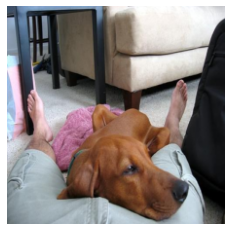

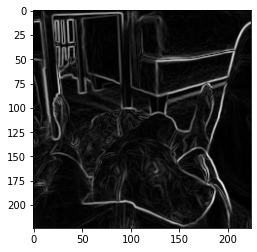

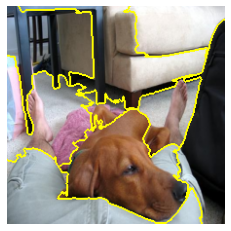

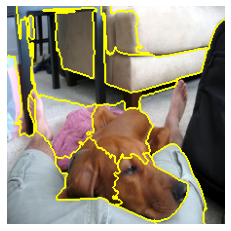

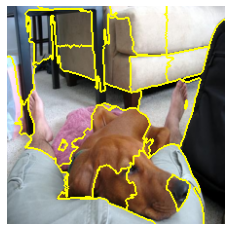

In [58]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))
plt.imshow(gradient, cmap='gray')

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply Watershed and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of Watershed
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

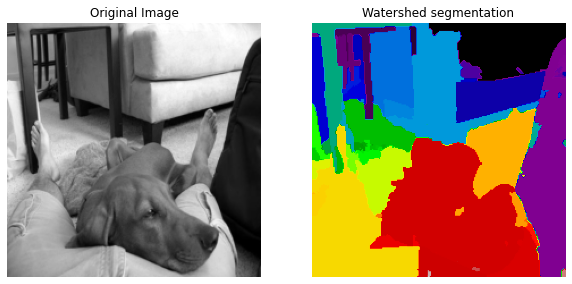

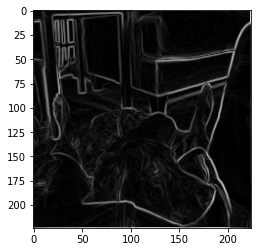

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F


def sobel_filter(image):
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        return np.array(True, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    return output <= connectivity

def label(input, structure=None, output=None):
    input = np.asarray(input)
    if np.iscomplexobj(input):
        raise TypeError('Complex type not supported')

    if structure is None:
        structure = generate_binary_structure(input.ndim, 1)
    structure = np.asarray(structure, dtype=bool)
    
    if structure.ndim != input.ndim:
        raise RuntimeError('structure and input must have equal rank')
    for ii in structure.shape:
        if ii != 3:
            raise ValueError('structure dimensions must be equal to 3')

    if isinstance(output, np.ndarray):
        if output.shape != input.shape:
            raise ValueError("output shape not correct")
        caller_provided_output = True
    else:
        caller_provided_output = False
        if output is None:
            output = np.empty(input.shape, np.int32)
        else:
            output = np.empty(input.shape, output)

    labeled_array, num_features = _label(input, structure, output)

    if caller_provided_output:
        return num_features
    else:
        return labeled_array, num_features

def _label(input, structure, output):
    """
    Internal labeling function that uses a flood fill algorithm to label connected components.
    """
    input = input.astype(bool)
    label = 1
    max_label = 0

    def flood_fill(x, y, label):
        queue = [(x, y)]
        while queue:
            cx, cy = queue.pop(0)
            if output[cx, cy] == 0 and input[cx, cy]:
                output[cx, cy] = label
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < input.shape[0] and 0 <= ny < input.shape[1]:
                        queue.append((nx, ny))

    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            if input[i, j] and output[i, j] == 0:
                flood_fill(i, j, label)
                label += 1
                max_label = label - 1

    return output, max_label

def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    # from scipy.ndimage import label, generate_binary_structure
    labeled, _ = label(markers)
    
    # structure = generate_binary_structure(2, 2)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()
    
    plt.imshow(gradient, cmap='gray')


watershed_from_scratch(image)

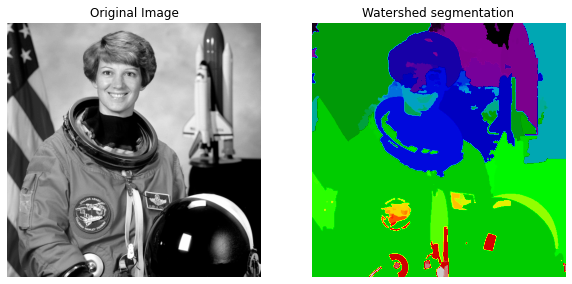

In [12]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import sobel
import heapq
from scipy.ndimage import label, generate_binary_structure

def rgb_to_grayscale(image):
    """
    Convert an RGB image to grayscale.
    """
    if len(image.shape) == 3 and image.shape[2] == 3:
        grayscale = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
        return grayscale
    else:
        raise ValueError("Input image must be an RGB image with 3 channels.")

class WatershedFromScratch(nn.Module):
    def __init__(self):
        super(WatershedFromScratch, self).__init__()

    def forward(self, image):
        # Compute the gradient magnitude of the image
        gradient = sobel(image.numpy())
        gradient = torch.tensor(gradient, dtype=torch.float32)

        # Generate markers
        markers = torch.zeros_like(image, dtype=torch.int64)
        markers[image < torch.tensor(np.percentile(image.numpy(), 10))] = 1
        markers[image > torch.tensor(np.percentile(image.numpy(), 90))] = 2

        # Simulate flooding process
        structure = generate_binary_structure(2, 2)
        labeled, _ = label(markers.numpy(), structure=structure)
        labeled = torch.tensor(labeled, dtype=torch.int64)

        heap = []
        for (i, j), value in np.ndenumerate(labeled.numpy()):
            if value > 0:
                heapq.heappush(heap, (gradient[i, j].item(), i, j, value))

        while heap:
            h, i, j, label_val = heapq.heappop(heap)
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    ni, nj = i + di, j + dj
                    if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                        if labeled[ni, nj] == 0:
                            labeled[ni, nj] = label_val
                            heapq.heappush(heap, (gradient[ni, nj].item(), ni, nj, label_val))

        return labeled

def watershed_from_scratch(image):
    model = WatershedFromScratch()
    labeled = model(torch.tensor(image, dtype=torch.float32))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()

image = np.asarray(data.astronaut())
grayscale_image = rgb_to_grayscale(image)
watershed_from_scratch(grayscale_image)

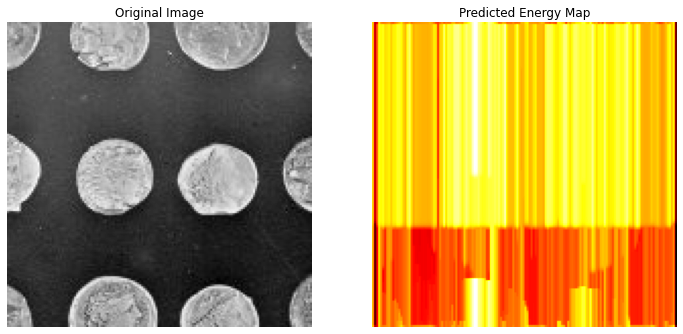

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

class EnergyMapPredictor(nn.Module):
    """ A simple CNN to predict an energy map from an image. """
    def __init__(self):
        super(EnergyMapPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def soft_watershed(energy_map, iterations=100, decay_factor=0.99):
    """ Perform a soft watershed algorithm. """
    h, w = energy_map.shape[-2:]
    grid_x, grid_y = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    grid_x = grid_x.float().to(energy_map.device)
    grid_y = grid_y.float().to(energy_map.device)
    
    # Initialize the water height as the negative energy map
    water_height = -energy_map.squeeze(1)

    for _ in range(iterations):
        # Compute local gradients
        grad_x = torch.roll(water_height, shifts=1, dims=0) - water_height
        grad_y = torch.roll(water_height, shifts=1, dims=1) - water_height

        # Flow water
        flow_x = F.relu(grad_x)
        flow_y = F.relu(grad_y)
        
        flow = flow_x + flow_y
        water_height += flow * decay_factor  # Update heights

    return water_height

def visualize(image, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(prediction.squeeze().detach().numpy(), cmap='hot')
    plt.title('Predicted Energy Map')
    plt.axis('off')
    plt.show()

# Load an example image
image = data.coins()[50:200, 50:200]  # Crop for simplicity
image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0  # CxHxW

# Model and prediction
model = EnergyMapPredictor()
predicted_energy_map = model(image)
watershed_output = soft_watershed(predicted_energy_map)

# Visualization
visualize(image, watershed_output)

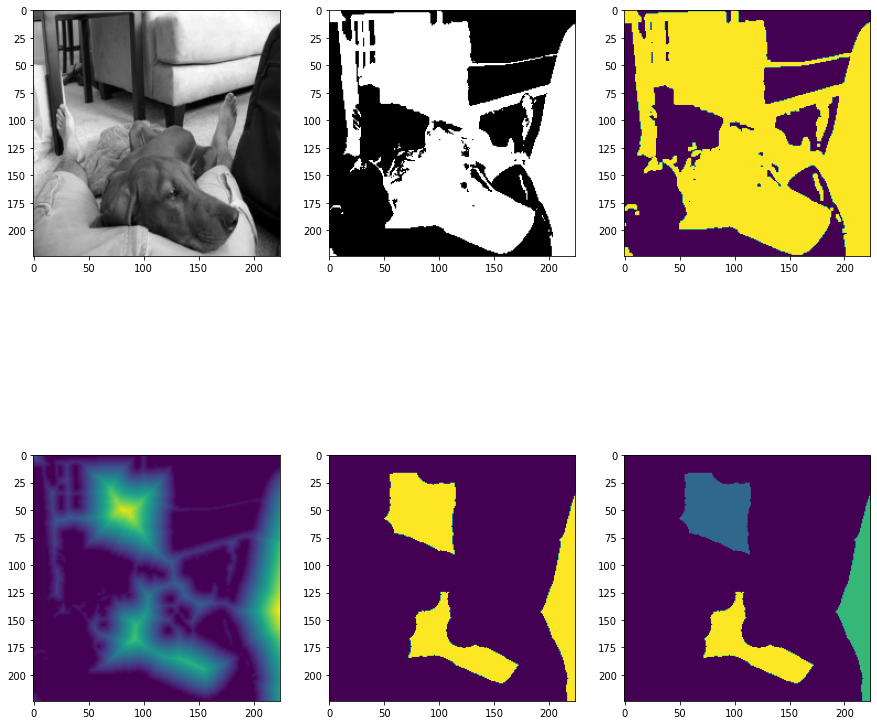

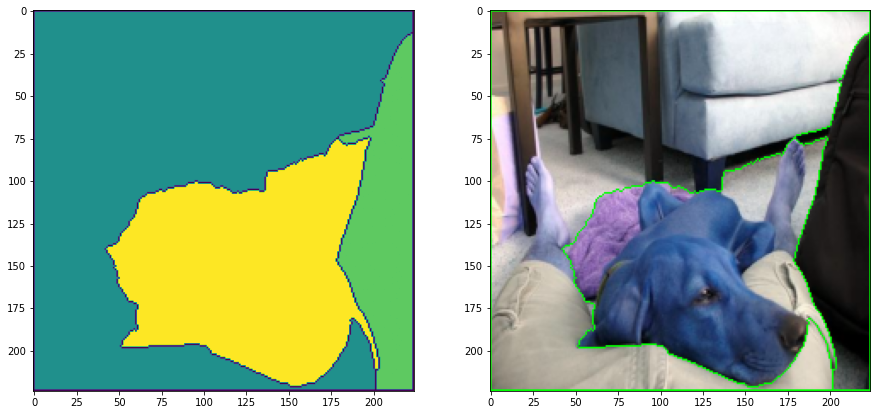

In [46]:
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np
import os

image, _ = train_dataset[random_index]

def watershed():
    img = np.asarray(image)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(231)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(232)
    _, imageThreshold = cv.threshold(img,120,255,cv.THRESH_BINARY_INV)
    plt.imshow(imageThreshold, cmap='gray')
    
    plt.subplot(233)
    kernel = np.ones((3,3),np.uint8)
    imgDilate = cv.morphologyEx(imageThreshold, cv.MORPH_DILATE, kernel)
    plt.imshow(imgDilate)
    
    plt.subplot(234)
    dist_transform = cv.distanceTransform(imgDilate, cv.DIST_L2, 5)
    plt.imshow(dist_transform)
    
    plt.subplot(235)
    _, distThresh = cv.threshold(dist_transform, 15, 255, cv.THRESH_BINARY)
    plt.imshow(distThresh)
    
    plt.subplot(236)
    distThresh = np.uint8(distThresh)
    _, labels = cv.connectedComponents(distThresh)
    plt.imshow(labels)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    labels = np.int32(labels)
    labels = cv.watershed(imgRGB, labels)
    plt.imshow(labels)
    
    plt.subplot(122)
    imgRGB[labels == -1] = [0,255,0]
    plt.imshow(imgRGB)
    
    
    plt.show()
    
watershed()

C:\Users\Contempt\AppData\Local\Temp\ipykernel_32996\3588170322.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distThresh = binary_threshold(torch.tensor(dist_transform))


RuntimeError: structure and input must have equal rank

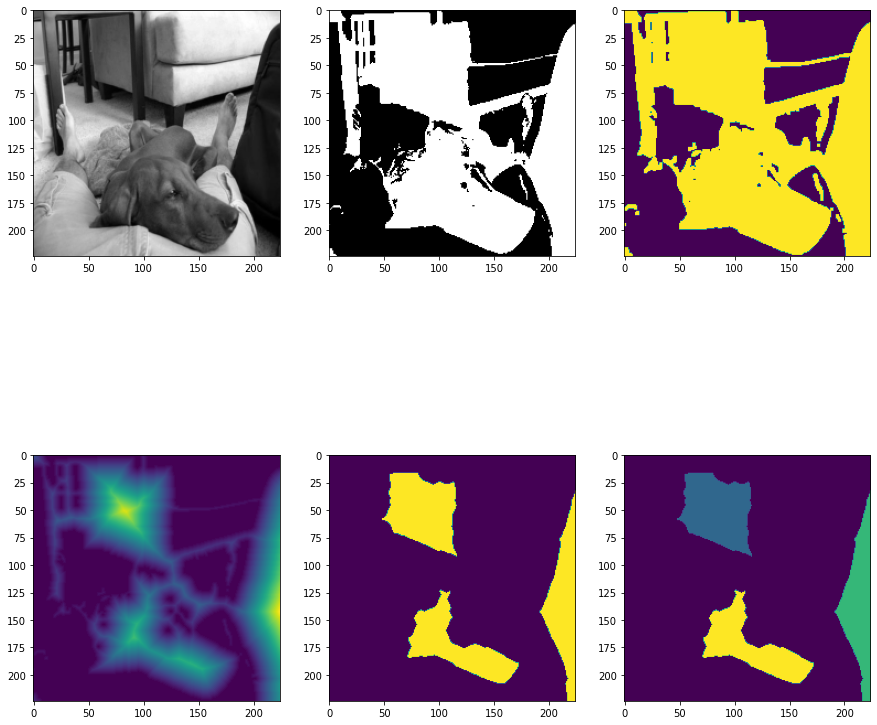

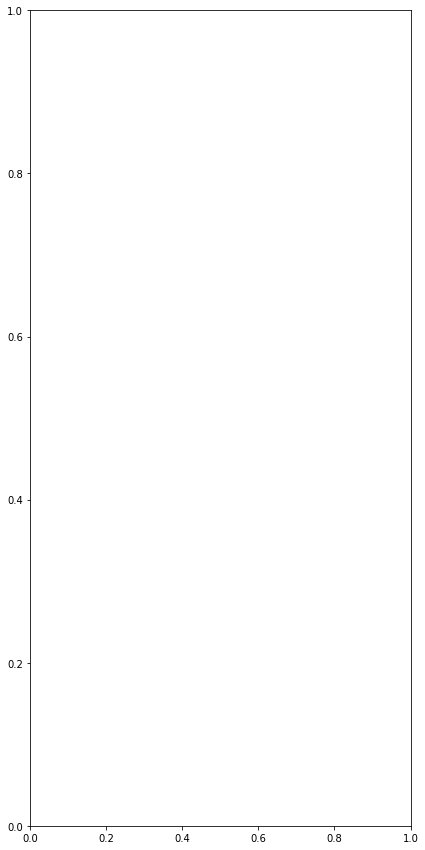

In [66]:
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F

image, _ = train_dataset[random_index]

class BinaryInverseThreshold(nn.Module):
    def __init__(self, threshold, max_value):
        super(BinaryInverseThreshold, self).__init__()
        self.threshold = threshold
        self.max_value = max_value

    
    def forward(self, img):
        img_threshold = torch.where(img > self.threshold, torch.tensor(0.0), torch.tensor(self.max_value))
        return img_threshold
    
    
class BinaryThreshold(nn.Module):
    def __init__(self, threshold, max_value):
        super(BinaryThreshold, self).__init__()
        self.threshold = threshold
        self.max_value = max_value

    def forward(self, img):
        # Apply binary thresholding
        img_threshold = torch.where(img > self.threshold, torch.tensor(self.max_value), torch.tensor(0.0))
        return img_threshold
    
class MorphologicalDilation(nn.Module):
    def __init__(self, kernel_size):
        super(MorphologicalDilation, self).__init__()
        self.kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32)

    def forward(self, img):
        if img.dim() == 2:
            img = img.unsqueeze(0).unsqueeze(0)
        elif img.dim() == 3 and img.size(0) == 1:
            img = img.unsqueeze(0)
        
        img_dilate = F.conv2d(img, self.kernel, padding=(self.kernel.size(2) // 2, self.kernel.size(3) // 2))
        img_dilate = torch.clamp(img_dilate, 0, 1)
        
        return img_dilate.squeeze()
    

ICV_DIST_SHIFT = 16
ICV_INIT_DIST0 = (2**31 - 1) >> 2

def icvInitTopBottom(temp, tempstep, size, border):
    for i in range(border):
        temp[i, :] = ICV_INIT_DIST0
        temp[size[0] + border*2 - i - 1, :] = ICV_INIT_DIST0

def icvDistanceTransform_3x3_C1R(src, srcstep, temp, step, dist, dststep, size, metrics):
    BORDER = 1
    HV_DIST = int(metrics[0] * (1 << ICV_DIST_SHIFT))
    DIAG_DIST = int(metrics[1] * (1 << ICV_DIST_SHIFT))
    scale = 1.0 / (1 << ICV_DIST_SHIFT)

    icvInitTopBottom(temp, step, size, BORDER)

    # Forward pass
    for i in range(size[0]):
        for j in range(size[1]):
            if src[i, j] == 0:
                temp[i + BORDER, j + BORDER] = 0
            else:
                t0 = temp[i + BORDER - 1, j + BORDER - 1] + DIAG_DIST
                t1 = temp[i + BORDER - 1, j + BORDER] + HV_DIST
                t2 = temp[i + BORDER - 1, j + BORDER + 1] + DIAG_DIST
                t3 = temp[i + BORDER, j + BORDER - 1] + HV_DIST
                temp[i + BORDER, j + BORDER] = min(t0, t1, t2, t3)

    # Backward pass
    for i in range(size[0] - 1, -1, -1):
        for j in range(size[1] - 1, -1, -1):
            t0 = temp[i + BORDER, j + BORDER]
            if t0 > HV_DIST:
                t1 = temp[i + BORDER + 1, j + BORDER + 1] + DIAG_DIST
                t2 = temp[i + BORDER + 1, j + BORDER] + HV_DIST
                t3 = temp[i + BORDER + 1, j + BORDER - 1] + DIAG_DIST
                t4 = temp[i + BORDER, j + BORDER + 1] + HV_DIST
                t0 = min(t0, t1, t2, t3, t4)
                temp[i + BORDER, j + BORDER] = t0
            dist[i, j] = t0 * scale

    return dist

class DistanceTransform(nn.Module):
    def __init__(self, max_iterations=1):
        super(DistanceTransform, self).__init__()
        self.max_iterations = max_iterations

    def forward(self, img):
        size = img.shape
        temp = torch.full((size[0] + 2, size[1] + 2), ICV_INIT_DIST0, dtype=torch.int32)
        dist = torch.zeros(size, dtype=torch.float32)
        
        metrics = [1.0, np.sqrt(2)]
        
        src = img.cpu().numpy().astype(np.uint8)
        temp = temp.cpu().numpy()
        dist = dist.cpu().numpy()
        
        dist = icvDistanceTransform_3x3_C1R(src, src.shape[1], temp, temp.shape[1], dist, dist.shape[1], size, metrics)
        
        return torch.tensor(dist, dtype=torch.float32)
    

    
    
class ConnectedComponents(nn.Module):
    def __init__(self):
        super(ConnectedComponents, self).__init__()

    def forward(self, img):
        img = img.squeeze(0).clone().cpu().numpy().astype(np.uint8)
        num_labels, labels = cv.connectedComponents(img, connectivity=8)
        return torch.tensor(labels, dtype=torch.int32).unsqueeze(0)
    
    
class WatershedFromScratch(nn.Module):
    def __init__(self):
        super(WatershedFromScratch, self).__init__()

    def forward(self, imgRGB, labels):
        # Convert imgRGB to grayscale if it's in RGB
        if imgRGB.dim() == 3 and imgRGB.size(0) == 3:
            imgRGB = rgb2gray(imgRGB.permute(1, 2, 0).cpu().numpy())
            imgRGB = torch.tensor(imgRGB, dtype=torch.float32, device=imgRGB.device)
        elif imgRGB.dim() == 2:
            imgRGB = imgRGB.float()

        # Compute the gradient magnitude of the image
        gradient = sobel(imgRGB.cpu().numpy())
        gradient = torch.tensor(gradient, dtype=torch.float32, device=imgRGB.device)

        # Use the provided labels as markers
        markers = labels.clone().detach().to(torch.int64).cpu().numpy()

        # Simulate flooding process
        structure = ndi.generate_binary_structure(2, 2)
        labeled, _ = ndi.label(markers, structure=structure)
        labeled = torch.tensor(labeled, dtype=torch.int64, device=imgRGB.device)

        heap = []
        for (i, j), value in np.ndenumerate(labeled.cpu().numpy()):
            if value > 0:
                heapq.heappush(heap, (gradient[i, j].item(), i, j, value))

        while heap:
            h, i, j, label_val = heapq.heappop(heap)
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    ni, nj = i + di, j + dj
                    if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                        if labeled[ni, nj] == 0:
                            labeled[ni, nj] = label_val
                            heapq.heappush(heap, (gradient[ni, nj].item(), ni, nj, label_val))

        return labeled
    
    
    
threshold_value = 120
max_value = 255
binary_inv_threshold = BinaryInverseThreshold(threshold_value, max_value)
binary_threshold = BinaryThreshold(15, 255)

kernel_size = 3
morph_dilate = MorphologicalDilation(kernel_size)

distance_transform = DistanceTransform(20)


connected_components = ConnectedComponents()

watershed_module = WatershedFromScratch()



def watershed():
    img = np.asarray(image)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(231)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(232)
    #_, imageThreshold = cv.threshold(img,120,255,cv.THRESH_BINARY_INV)
    imageThreshold = binary_inv_threshold(torch.tensor(img))
    plt.imshow(imageThreshold, cmap='gray')
    
    plt.subplot(233)
    imgDilate = morph_dilate(imageThreshold)
    plt.imshow(imgDilate)
    
    plt.subplot(234)
    dist_transform = distance_transform(imgDilate)
    plt.imshow(dist_transform)
    
    plt.subplot(235)
    distThresh = binary_threshold(torch.tensor(dist_transform))
    #_, distThresh = cv.threshold(dist_transform, 15, 255, cv.THRESH_BINARY)
    plt.imshow(distThresh)
    
    plt.subplot(236)
    labels = connected_components(distThresh.unsqueeze(0))
    plt.imshow(labels[0])
    
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    water_labels = watershed_module(torch.tensor(imgRGB, dtype=torch.float32), labels)
    plt.imshow(water_labels[0])
    
    assert 0
    plt.subplot(122)
    imgRGB[labels == -1] = [0,255,0]
    plt.imshow(imgRGB)
    
    
    plt.show()
    
watershed()

In [14]:
import torch
import torch.nn.functional as F
from scipy.ndimage import sobel

class DifferentiableWatershed(torch.nn.Module):
    def __init__(self, num_markers):
        super(DifferentiableWatershed, self).__init__()
        self.num_markers = num_markers
        self.marker_net = torch.nn.Conv2d(1, num_markers, kernel_size=1)  # Network to predict markers

    def forward(self, x):
        # Compute gradient
        grad_x = torch.tensor(sobel(x.cpu().numpy(), axis=2), device=x.device).unsqueeze(1)
        grad_y = torch.tensor(sobel(x.cpu().numpy(), axis=3), device=x.device).unsqueeze(1)
        grad_mag = torch.sqrt(grad_x**2 + grad_y**2)

        # Predict markers
        markers = self.marker_net(x)
        markers = F.softmax(markers, dim=1)

        # Initialize labels with markers
        labels = torch.argmax(markers, dim=1).float()

        # Soft flooding process
        for _ in range(10):  # Number of flooding iterations
            labels = self.soft_flooding(labels, grad_mag)

        return labels

    def soft_flooding(self, labels, grad_mag):
        # Ensure grad_mag is correctly shaped for convolution
        batch_size, _, height, width = labels.shape
        grad_mag = grad_mag.repeat(batch_size, 1, 1, 1)  # Match batch size
        grad_inv = 1 / (grad_mag + 1e-6)

        # Create a kernel for convolution, shape (batch_size, 1, height, width)
        grad_inv_kernel = grad_inv.unsqueeze(1)

        # Apply convolution
        new_labels = F.conv2d(labels.unsqueeze(1), grad_inv_kernel, padding=1, groups=batch_size).squeeze(1)
        return new_labels

# Example usage
x = torch.rand(1, 1, 128, 128)  # Example input image
model = DifferentiableWatershed(num_markers=10)
labels = model(x)

print(labels)


ValueError: not enough values to unpack (expected 4, got 3)

# WATERPIXELS

In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
import scipy.spatial as sp

In [93]:
def preprocessing(ima, step):
    im = morpho.area_opening(ima, area_threshold= step*step/16)
    im = morpho.area_closing(im, area_threshold= step*step/16)
    return im

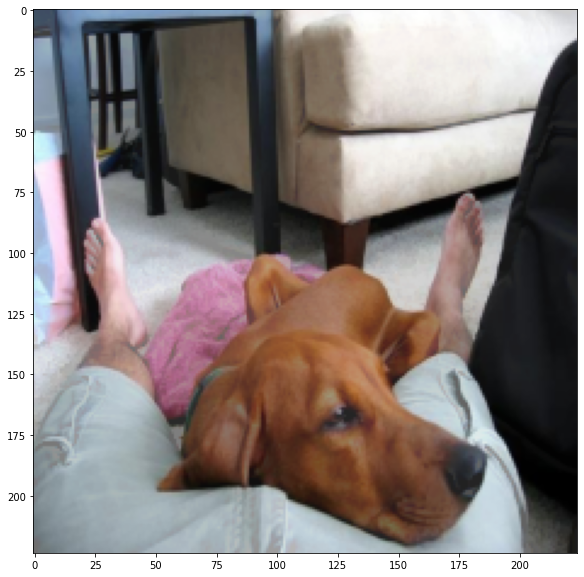

In [94]:
image = np.array(image)
ima = preprocessing(image,30)
plt.figure(figsize = (10,10))
plt.imshow(ima,cmap='gray')
plt.show()

In [90]:
# Gradient horizental
def sobelGradX(ima):

    nl,nc=ima.shape
    gradx=np.zeros((nl,nc))
    for i in range(1,nl-1):
        for j in range(1,nc-1):
            gradx[i,j]=ima[i-1,j+1]+2*ima[i,j+1]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i,j-1]-ima[i+1,j-1];
            
    return gradx

# Gradient vertical
def sobelGradY(ima):

    nl,nc=ima.shape
    grady=np.zeros((nl,nc))
    for i in range(1,nl-1):
        for j in range(1,nc-1):
            grady[i,j]=ima[i+1,j-1]+2*ima[i+1,j]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i-1,j]-ima[i-1,j+1];
        
    return grady

# Norme du gradient
def sobel_normeGradient(ima):
    gradx=sobelGradX(ima)
    grady=sobelGradY(ima)
    nl,nc=gradx.shape
    norme=np.zeros((nl,nc))
    for i in range(nl):
        for j in range(nc):
            norme[i,j]=np.sqrt(gradx[i,j]*gradx[i,j]+grady[i,j]*grady[i,j])
            
    return norme

In [87]:
def gradmorpho(img):

  strell = morpho.disk(1)
  morpho_grad = morpho.dilation(img,strell) - morpho.erosion(img, strell)

  return morpho_grad

In [88]:
def gradientlab(img):

  lab = color.rgb2lab(img)
  l = lab[:,:,0]
  gradlab=sobel_normeGradient(l)

  return gradlab

In [91]:
# Gradient de Sobel
gradsob=sobel_normeGradient(ima)

# Gradient morphologique
grad_morpho = gradmorpho(ima)

# Gradient Lab
gradlab = gradientlab(image)

# Affichage des gradients
fig,ax = plt.subplots(2,2,figsize = (20,15))
ax[0,0].imshow(image)
ax[0,0].set_title('Image originale')
ax[0,1].imshow(gradsob,cmap = "gray")
ax[0,1].set_title('Gradient de Sobel')
ax[1,0].imshow(grad_morpho,cmap = "gray")
ax[1,0].set_title('Gradient morphologique')
ax[1,1].imshow(gradlab,cmap = "gray")
ax[1,1].set_title('Gradient Lab')
plt.show()

ValueError: too many values to unpack (expected 2)